<a href="https://colab.research.google.com/github/niplessa/Thesis_Data-mining-study-on-medical-and-sociological-Data-regarding-Covid19/blob/code/NLP_4_Tweets_separate_DFs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Eda & Clustering & Sentiment analysis on Covid-19 tweets (sub-topics)

Dataset accessed from: https://www.kaggle.com/gpreda/covid19-tweets

In [ ]:
#import libraries

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 40000)
pd.set_option('display.max_columns', 600)
pd.set_option('display.width', 3000)
#pd.set_option('display.max_colwidth', 50)

import  matplotlib.pyplot as plt
import  seaborn as sns
sns.set_style("whitegrid")
import plotly.express as px

from wordcloud import WordCloud

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.tokenize import regexp_tokenize 
from string import punctuation
from nltk.stem import WordNetLemmatizer 

from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

import re

import string
from string import punctuation

stopwords_eng = stopwords.words('english')


In [ ]:
!pip install NRCLex
!python -m textblob.download_corpora

In [ ]:
from nrclex import NRCLex

## Import Tweets

In [ ]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#for kaggle tweets
path = '/content/drive/My Drive/datasets/covid19_tweets.csv'
tweets = pd.read_csv(path)

In [ ]:
tweets = tweets.drop_duplicates(subset="text", keep = "first")   #drop duplicate tweets
tweets.text = tweets.text.astype('str')

In [ ]:
tweets.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
0,ᏉᎥ☻լꂅϮ,astroworld,wednesday addams as a disney princess keepin i...,2017-05-26 05:46:42,624,950,18775,False,2020-07-25 12:27:21,If I smelled the scent of hand sanitizers toda...,NaN,Twitter for iPhone,False
1,Tom Basile 🇺🇸,"New York, NY","Husband, Father, Columnist & Commentator. Auth...",2009-04-16 20:06:23,2253,1677,24,True,2020-07-25 12:27:17,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,NaN,Twitter for Android,False
2,Time4fisticuffs,"Pewee Valley, KY",#Christian #Catholic #Conservative #Reagan #Re...,2009-02-28 18:57:41,9275,9525,7254,False,2020-07-25 12:27:14,@diane3443 @wdunlap @realDonaldTrump Trump nev...,['COVID19'],Twitter for Android,False
3,ethel mertz,Stuck in the Middle,#Browns #Indians #ClevelandProud #[]_[] #Cavs ...,2019-03-07 01:45:06,197,987,1488,False,2020-07-25 12:27:10,@brookbanktv The one gift #COVID19 has give me...,['COVID19'],Twitter for iPhone,False
4,DIPR-J&K,Jammu and Kashmir,🖊️Official Twitter handle of Department of Inf...,2017-02-12 06:45:15,101009,168,101,False,2020-07-25 12:27:08,25 July : Media Bulletin on Novel #CoronaVirus...,"['CoronaVirusUpdates', 'COVID19']",Twitter for Android,False


In [ ]:
tweets.tail()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
179103,AJIMATI AbdulRahman O.,"Ilorin, Nigeria",Animal Scientist|| Muslim|| Real Madrid/Chelsea,2013-12-30 18:59:19,412,1609,1062,False,2020-08-29 19:44:21,Thanks @IamOhmai for nominating me for the @WH...,['WearAMask'],Twitter for Android,False
179104,Jason,Ontario,When your cat has more baking soda than Ninja ...,2011-12-21 04:41:30,150,182,7295,False,2020-08-29 19:44:16,2020! The year of insanity! Lol! #COVID19 http...,['COVID19'],Twitter for Android,False
179105,BEEHEMOTH ⏳,🇨🇦 Canada,⚒️ The Architects of Free Trade ⚒️ Really Did ...,2016-07-13 17:21:59,1623,2160,98000,False,2020-08-29 19:44:15,@CTVNews A powerful painting by Juan Lucena. I...,NaN,Twitter Web App,False
179106,Gary DelPonte,New York City,"Global UX UI Visual Designer. StoryTeller, Mus...",2009-10-27 17:43:13,1338,1111,0,False,2020-08-29 19:44:14,"More than 1,200 students test positive for #CO...",['COVID19'],Twitter for iPhone,False
179107,TUKY II,"Aliwal North, South Africa",TOKELO SEKHOPA | TUKY II | LAST BORN | EISH TU...,2018-04-14 17:30:07,97,1697,566,False,2020-08-29 19:44:08,I stop when I see a Stop\n\n@SABCNews\n@Izinda...,NaN,Twitter for Android,False


In [ ]:
tweets.shape

(178683, 13)

## NLP text preprocess

In [ ]:
from nltk.corpus import wordnet
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [ ]:
lemmatizer = WordNetLemmatizer()

In [ ]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)


In [ ]:

#lematization function
from nltk.corpus import wordnet

def lemmatize_text(text):
    lemmatized = []
    for word in text:
        lemmatized.append(lemmatizer.lemmatize(word,get_wordnet_pos(word)))
    return lemmatized

#remove stopwords function
stops =  list(stopwords_eng)
def remove_stops(text):
    text_no_stops = []
    for i in text:
        if i not in stops:
            if len(i) == 1:
                pass
            else:
                text_no_stops.append(i)
        else:
            pass
    return text_no_stops

In [ ]:
tweets['clean_text'] = tweets['text'].astype(str)

#replace newline char with space
tweets['clean_text'] = tweets['text'].str.replace("\n", " ")

# make all text lowercase
tweets['clean_text'] = tweets['text'].apply(lambda x: x.lower())

# removing everything except alphabets
tweets['clean_text'] = tweets['clean_text'].str.replace("[^a-zA-Z]", " ")

# removing short words <3 letters length
tweets['clean_text'] = tweets['clean_text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

In [ ]:
#remove links with regex
p=re.compile('(www|http)\S+')
tweets['clean_text'] = tweets['clean_text'].apply(lambda x: re.sub(p,' ',x))

#remove @
tweets['clean_text'] = tweets['clean_text'].apply(lambda x: re.sub('@','',x))

#remove #
tweets['clean_text'] = tweets['clean_text'].apply(lambda x: re.sub('#','',x))

In [ ]:
# tokenization
tweets['text_tokenized'] = tweets['clean_text'].apply(lambda x: regexp_tokenize(x,"[\w']+"))

#actually remove stopwords
tweets['text_tokenized'] = tweets['text_tokenized'].apply(lambda x: remove_stops(x))

In [ ]:
#lemmatization
tweets['text_lemmatized'] = tweets['text_tokenized'].apply(lemmatize_text)

In [ ]:
#stemming
from nltk.stem import PorterStemmer 
ps = PorterStemmer() 
tweets['text_stemmed'] = tweets['text_tokenized'].apply(lambda x: [ps.stem(y) for y in x])

In [ ]:
#de - tokenization
tweets['stemmed_string'] = tweets['text_stemmed'].apply(lambda x: ' '.join(x))
tweets['lemmatized_string'] = tweets['text_lemmatized'].apply(lambda x: ' '.join(x))

In [ ]:
tweets.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,clean_text,text_tokenized,text_lemmatized,text_stemmed,stemmed_string,lemmatized_string
0,ᏉᎥ☻լꂅϮ,astroworld,wednesday addams as a disney princess keepin i...,2017-05-26 05:46:42,624,950,18775,False,2020-07-25 12:27:21,If I smelled the scent of hand sanitizers toda...,NaN,Twitter for iPhone,False,smelled scent hand sanitizers today someone pa...,"[smelled, scent, hand, sanitizers, today, some...","[smell, scent, hand, sanitizers, today, someon...","[smell, scent, hand, sanit, today, someon, pas...",smell scent hand sanit today someon past would...,smell scent hand sanitizers today someone past...
1,Tom Basile 🇺🇸,"New York, NY","Husband, Father, Columnist & Commentator. Auth...",2009-04-16 20:06:23,2253,1677,24,True,2020-07-25 12:27:17,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,NaN,Twitter for Android,False,yankees yankeespr wouldn have made more sense ...,"[yankees, yankeespr, made, sense, players, res...","[yankee, yankeespr, make, sense, player, respe...","[yanke, yankeespr, made, sens, player, respect...",yanke yankeespr made sens player respect zgypu,yankee yankeespr make sense player respect zgypu
2,Time4fisticuffs,"Pewee Valley, KY",#Christian #Catholic #Conservative #Reagan #Re...,2009-02-28 18:57:41,9275,9525,7254,False,2020-07-25 12:27:14,@diane3443 @wdunlap @realDonaldTrump Trump nev...,['COVID19'],Twitter for Android,False,diane wdunlap realdonaldtrump trump never once...,"[diane, wdunlap, realdonaldtrump, trump, never...","[diane, wdunlap, realdonaldtrump, trump, never...","[dian, wdunlap, realdonaldtrump, trump, never,...",dian wdunlap realdonaldtrump trump never claim...,diane wdunlap realdonaldtrump trump never clai...
3,ethel mertz,Stuck in the Middle,#Browns #Indians #ClevelandProud #[]_[] #Cavs ...,2019-03-07 01:45:06,197,987,1488,False,2020-07-25 12:27:10,@brookbanktv The one gift #COVID19 has give me...,['COVID19'],Twitter for iPhone,False,brookbanktv gift covid give appreciation simpl...,"[brookbanktv, gift, covid, give, appreciation,...","[brookbanktv, gift, covid, give, appreciation,...","[brookbanktv, gift, covid, give, appreci, simp...",brookbanktv gift covid give appreci simpl thin...,brookbanktv gift covid give appreciation simpl...
4,DIPR-J&K,Jammu and Kashmir,🖊️Official Twitter handle of Department of Inf...,2017-02-12 06:45:15,101009,168,101,False,2020-07-25 12:27:08,25 July : Media Bulletin on Novel #CoronaVirus...,"['CoronaVirusUpdates', 'COVID19']",Twitter for Android,False,july media bulletin novel coronavirusupdates c...,"[july, media, bulletin, novel, coronavirusupda...","[july, medium, bulletin, novel, coronavirusupd...","[juli, media, bulletin, novel, coronavirusupd,...",juli media bulletin novel coronavirusupd covid...,july medium bulletin novel coronavirusupdates ...


# Create separate dataframes for subjects such as masks, vaccines, protests, poverty/economica crisis, hoax etc etc

## Masks

In [ ]:
#Mask keywords
keywords_masks = ["mask","facemask","masks","mask","facecover","face","face cover ","face mask","protective mask"]

In [ ]:
tweet_masks = pd.DataFrame()

for k in keywords_masks :
    tmp = tweets[tweets['clean_text'].str.lower().str.contains(k)]
    tweet_masks = tweet_masks.append(tmp)
    
    
    
tweet_masks.sort_values("date", inplace = True,ascending = False)   #sort by date
tweet_masks.drop_duplicates(subset="clean_text", keep = "first", inplace = True)        #drop duplicate tweets
                      
tweet_masks = tweet_masks.reset_index(drop=True) #reset index
print("Mask related tweets: ",tweet_masks.shape[0])

Mask related tweets:  10024


## Vaccine

In [ ]:
#vaccine keywords
keywords = ["vaccine","vaccines","pfizer","moderna","astrazeneca","oxford","sputnik","vaccination"]

In [ ]:
tweet_vacc = pd.DataFrame()

for k in keywords :
    tmp = tweets[tweets['clean_text'].str.lower().str.contains(k)]
    tweet_vacc = tweet_vacc.append(tmp)
    
    
    
tweet_vacc.sort_values("date", inplace = True,ascending = False)   #sort by date
tweet_vacc.drop_duplicates(subset="clean_text", keep = "first", inplace = True)        #drop duplicate tweets
                      
tweet_vacc = tweet_vacc.reset_index(drop=True) #reset index
print("Vaccine related tweets: ",tweet_vacc.shape[0])

Vaccine related tweets:  4367


## Protests - Riots

In [ ]:
#protests
keywords = ["protest","protester","anti","clash","demonstration","conflict","riot"]

In [ ]:
tweet_protest = pd.DataFrame()

for k in keywords :
    tmp = tweets[tweets['clean_text'].str.lower().str.contains(k)]
    tweet_protest = tweet_protest.append(tmp)
    
    
    
tweet_protest.sort_values("date", inplace = True,ascending = False)   #sort by date
tweet_protest.drop_duplicates(subset="clean_text", keep = "first", inplace = True)        #drop duplicate tweets
                      
tweet_protest = tweet_protest.reset_index(drop=True) #reset index
print("Protest related tweets: ",tweet_protest.shape[0])

## Hoax/Deniers

In [ ]:
#hoax / deniers
keywords = ["hoax","plandemic","china virus","CoronaJihad","Chinesevirus","bioweapon","flu","chinavirus","fake","fakevirus"]

In [ ]:
tweet_hoax = pd.DataFrame()

for k in keywords :
    tmp = tweets[tweets['clean_text'].str.lower().str.contains(k)]
    tweet_hoax = tweet_hoax.append(tmp)
    
    
    
tweet_hoax.sort_values("date", inplace = True,ascending = False)   #sort by date
tweet_hoax.drop_duplicates(subset="clean_text", keep = "first", inplace = True)        #drop duplicate tweets
                      
tweet_hoax = tweet_hoax.reset_index(drop=True) #reset index
print("Hoax related tweets: ",tweet_hoax.shape[0])

# Wordclouds

## Masks

In [ ]:
text = tweet_masks.lemmatized_string
wordcloud = WordCloud(
    max_words = 100, 
    width = 2000,
    height = 1000,
    background_color = 'black',
    ).generate(str(text))
fig = plt.figure(
    figsize = (30, 20),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

## Vaccines

In [ ]:
text = tweet_vacc.lemmatized_string
wordcloud = WordCloud(
    max_words = 100, 
    width = 2000,
    height = 1000,
    background_color = 'black',
    ).generate(str(text))
fig = plt.figure(
    figsize = (30, 20),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

## Protests

In [ ]:
text = tweet_protest.lemmatized_string
wordcloud = WordCloud(
    max_words = 100, 
    width = 2000,
    height = 1000,
    background_color = 'black',
    ).generate(str(text))
fig = plt.figure(
    figsize = (30, 20),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

## Hoax

In [ ]:
text = tweet_hoax.lemmatized_string
wordcloud = WordCloud(
    max_words = 100, 
    width = 2000,
    height = 1000,
    background_color = 'black',
    ).generate(str(text))
fig = plt.figure(
    figsize = (30, 20),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

K-means text clustering: 
https://medium.com/@lucasdesa/text-clustering-with-k-means-a039d84a941b

# Masks Dataframe

In [ ]:
tweet_masks.head()

##TFIDF Vectorizer

In [ ]:
vectorizer = TfidfVectorizer(stop_words=stopwords_eng, 
max_features= 1000, # keep top 1000 terms
max_df=0.3, 
min_df = 50, 
smooth_idf=True,
use_idf = True,
ngram_range=(1,2))

#vectorizer = TfidfVectorizer(use_idf = True, ngram_range=(1,2))

 
X = vectorizer.fit_transform(tweet_masks['lemmatized_string'])
terms = vectorizer.get_feature_names()

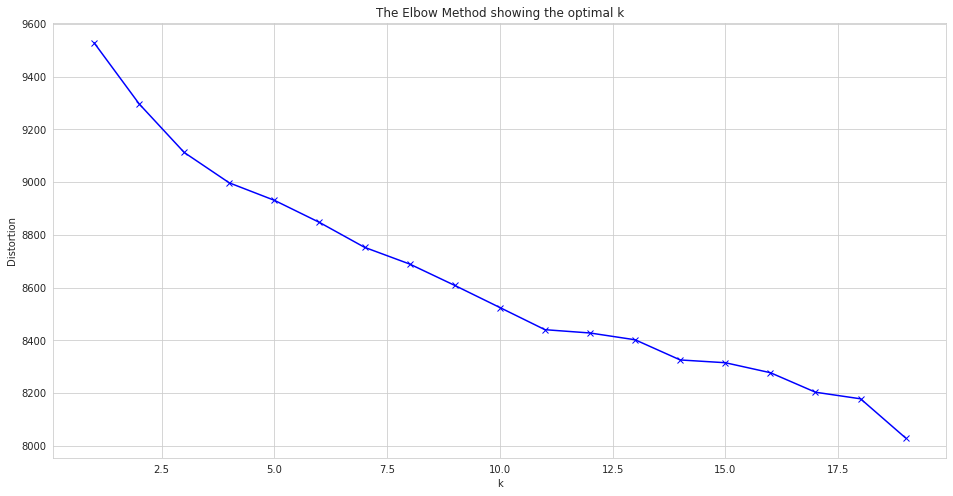

In [ ]:
#elbow method
sns.set_style("whitegrid")
distortions = []
K = range(1,20)
for k in K:
    km = KMeans(n_clusters=k)
    km.fit(X)
    distortions.append(km.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

## Kmeans Clustering

In [ ]:
num_clusters = 12

km = KMeans(n_clusters=num_clusters,init='k-means++', max_iter=100, n_init=10, random_state=1)

labels = km.fit_predict(X)

In [ ]:
tweet_masks['cluster'] = labels

In [ ]:
#most important n-gramms (words) in each cluster

print("K-means clustering: \n")
asc_order_centroids = km.cluster_centers_.argsort()#[:, ::-1]
order_centroids = asc_order_centroids[:,::-1]
terms = vectorizer.get_feature_names()
for i in range(num_clusters):
    print ("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print (' %s' % terms[ind])
    print('\n')


K-means clustering: 

Cluster 0:
 covid mask
 make
 face
 face mask
 mandate
 wear
 mask covid
 maskup
 coronavirus covid
 coronavirus


Cluster 1:
 shield
 face shield
 face
 protective
 fight covid
 fight
 mask face
 wear
 wear face
 face mask


Cluster 2:
 facebook
 maskup
 make
 mandate
 need
 like
 wearadamnmask
 take
 work
 case


Cluster 3:
 social distance
 social
 distance
 mask social
 wear
 wear mask
 hand
 wash
 distance wear
 wash hand


Cluster 4:
 wearamask
 covid wearamask
 wearamask covid
 wearamask challenge
 challenge
 love
 one
 love one
 yuvstrong
 keep


Cluster 5:
 coronavirus
 covid coronavirus
 coronavirus covid
 pandemic
 wearamask
 face
 covid covid
 wear
 maskup
 news


Cluster 6:
 face
 face mask
 wear face
 wear
 cover
 covering
 face cover
 face covering
 face covid
 challenge


Cluster 7:
 wear mask
 wear
 mask wear
 please
 everyone
 spread
 take
 keep
 protect
 make


Cluster 8:
 facemasks
 healthandsafety
 shoppingonline
 gift
 onlineshopping
 healtha

## Plot Cluster Size

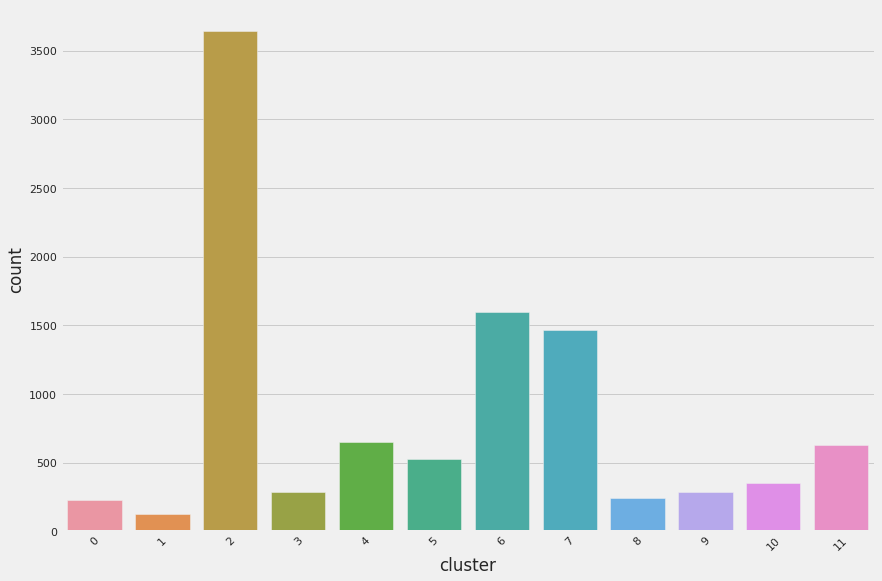

In [ ]:
sns.set(rc={'figure.figsize':(13,9)})
plt.style.use('fivethirtyeight')
ax = sns.countplot(x='cluster', data=tweet_masks)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.show()

##Sentiment Analysis

In [ ]:
tweet_masks['emotion']=''

In [ ]:
for i in range(1,tweet_masks.shape[0]):
  text = tweet_masks['lemmatized_string'][i]
  text_object = NRCLex(text)
  tweet_masks['emotion'][i] = text_object.top_emotions[0][0]
  #tweets['emotion_score'][i] = text_object.top_emotions[0][1]
  #print("\n")
  #print(text_object.words)
  #print(text_object.top_emotions)
  #print(i)
  #print("\n")

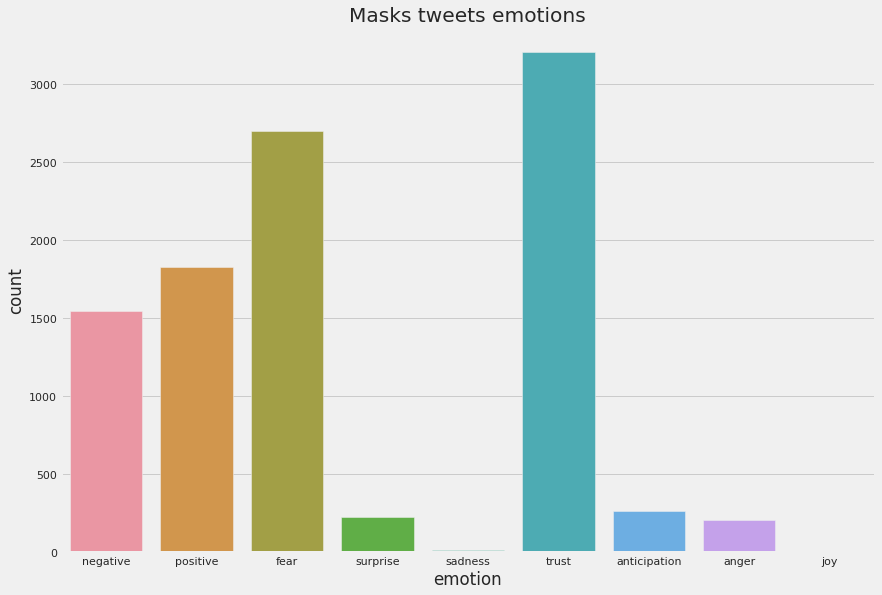

In [ ]:
ax = sns.countplot(x= 'emotion', data=tweet_masks, order=['negative', 'positive', 'fear', 'surprise', 'sadness','trust','anticipation','anger', 'joy'])\
.set_title('Masks tweets emotions')
plt.show()

# Vaccines dataframe

In [ ]:
tweet_vacc.head()

,index,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,clean_text,text_tokenized,text_lemmatized,text_stemmed,stemmed_string,lemmatized_string,day
0,166718,Pragyan Mishra,Hyderabad | Vizag | Delhi,Loquacious | Trying to wake up from repeated b...,2014-06-27 10:38:14,93,180,162,False,2020-08-30 09:04:31,Religious leaders who claim that vaccination i...,NaN,Twitter for Android,False,religious leaders claim that vaccination again...,"[religious, leaders, claim, vaccination, wishe...","[religious, leader, claim, vaccination, wish, ...","[religi, leader, claim, vaccin, wish, allow, d...",religi leader claim vaccin wish allow develop,religious leader claim vaccination wish allow ...,2020-08-30
1,166751,stefano monzo,"London, England",Chase your passion (not you pension!). Digital...,2013-06-07 09:09:07,1213,882,1056,False,2020-08-30 09:02:45,"""Short cuts in testing for #vaccine safety and...",['vaccine'],Twitter for Android,False,short cuts testing vaccine safety efficacy end...,"[short, cuts, testing, vaccine, safety, effica...","[short, cut, test, vaccine, safety, efficacy, ...","[short, cut, test, vaccin, safeti, efficaci, e...",short cut test vaccin safeti efficaci endang m...,short cut test vaccine safety efficacy endange...,2020-08-30
2,166772,Constantinos Tsioutis,Cyprus,Asst. Prof @EuropeanUniCy. \nInternal Medicine...,2017-06-11 15:28:40,577,439,3746,True,2020-08-30 09:01:52,Some good reads on considerations related to #...,"['COVID19', 'vaccine']",Twitter Web App,False,some good reads considerations related covid v...,"[good, reads, considerations, related, covid, ...","[good, read, consideration, related, covid, va...","[good, read, consider, relat, covid, vaccin, t...",good read consider relat covid vaccin trial ef...,good read consideration related covid vaccine ...,2020-08-30
3,166802,DTR Medical ®,Swansea,Multiple award winning medical device manufact...,2010-09-12 15:44:37,3235,3681,1473,False,2020-08-30 09:00:50,COVID-19 vaccine studies volunteers’ figures a...,"['vaccine', 'NHS', 'COVID19']",Hootsuite Inc.,False,covid vaccine studies volunteers figures visib...,"[covid, vaccine, studies, volunteers, figures,...","[covid, vaccine, study, volunteer, figure, vis...","[covid, vaccin, studi, volunt, figur, visibl, ...",covid vaccin studi volunt figur visibl digit d...,covid vaccine study volunteer figure visible d...,2020-08-30
4,166929,Sollencia,United States,"The latest world, business, stock market, scie...",2015-09-04 03:53:27,21,99,5,False,2020-08-30 08:55:29,#Moderna says its #Covid19 vaccine shows promi...,"['Moderna', 'Covid19']",Twitter Web App,False,moderna says covid vaccine shows promising res...,"[moderna, says, covid, vaccine, shows, promisi...","[moderna, say, covid, vaccine, show, promising...","[moderna, say, covid, vaccin, show, promis, re...",moderna say covid vaccin show promis result ol...,moderna say covid vaccine show promising resul...,2020-08-30


##TFIDF Vectorizer

In [ ]:
vectorizer = TfidfVectorizer(stop_words=stopwords_eng, 
max_features= 1000, # keep top 1000 terms
max_df=0.3, 
min_df = 50, 
smooth_idf=True,
use_idf = True,
ngram_range=(1,2))

#vectorizer = TfidfVectorizer(use_idf = True, ngram_range=(1,2))

 
X = vectorizer.fit_transform(tweet_vacc['lemmatized_string'])
terms = vectorizer.get_feature_names()

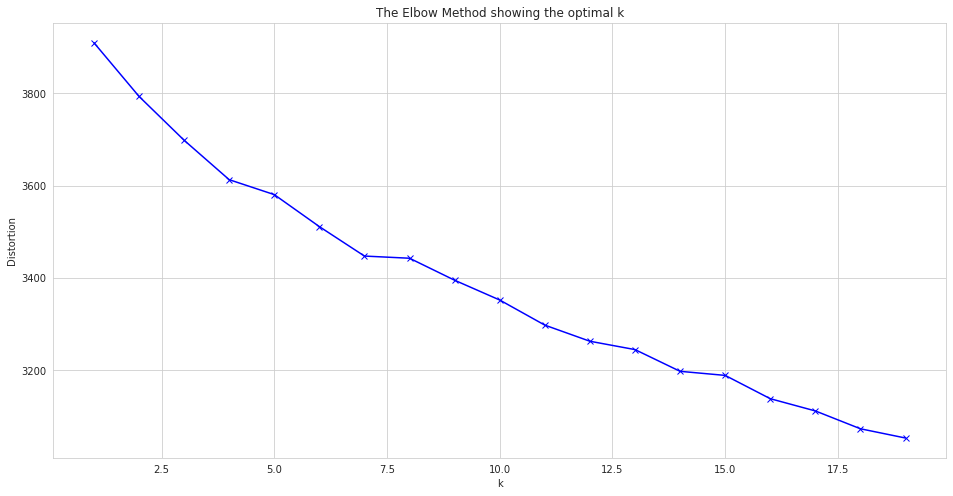

In [ ]:
#elbow method
sns.set_style("whitegrid")
distortions = []
K = range(1,20)
for k in K:
    km = KMeans(n_clusters=k)
    km.fit(X)
    distortions.append(km.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

## Kmeans Clustering

In [ ]:
num_clusters = 10

km = KMeans(n_clusters=num_clusters,init='k-means++', max_iter=100, n_init=10, random_state=1)

labels = km.fit_predict(X)

In [ ]:
tweet_vacc['cluster'] = labels

In [ ]:
#most important n-gramms (words) in each cluster

print("K-means clustering: \n")
asc_order_centroids = km.cluster_centers_.argsort()#[:, ::-1]
order_centroids = asc_order_centroids[:,::-1]
terms = vectorizer.get_feature_names()
for i in range(num_clusters):
    print ("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print (' %s' % terms[ind])
    print('\n')


K-means clustering: 

Cluster 0:
 russia
 first
 first covid
 first covid vaccine
 world
 world first
 putin
 register
 country
 russia covid


Cluster 1:
 coronavirus
 coronavirus vaccine
 covid coronavirus
 coronavirus covid
 russia
 coronavaccine
 news
 coronavirusvaccine
 race
 say


Cluster 2:
 trial
 vaccine trial
 covid vaccine trial
 phase
 clinical
 clinical trial
 trial covid
 phase trial
 volunteer
 moderna


Cluster 3:
 vaccination
 plan
 would
 pandemic
 russia
 year
 coronavirus
 safe
 news
 health


Cluster 4:
 vaccine covid
 russia
 even
 find
 russian
 need
 first
 could
 available
 say


Cluster 5:
 effective
 safe
 fauci
 vaccine covid
 develop
 coronavirus
 race
 world
 need
 china


Cluster 6:
 putin
 putin say
 president
 say
 first
 russia
 vladimir
 vladimir putin
 president vladimir
 daughter


Cluster 7:
 take
 would
 vaccine covid
 russian
 year
 trump
 vaccination
 volunteer
 even
 come


Cluster 8:
 ready
 say
 india
 oxford
 human
 trial
 year
 could
 russ

## Plot Cluster Size

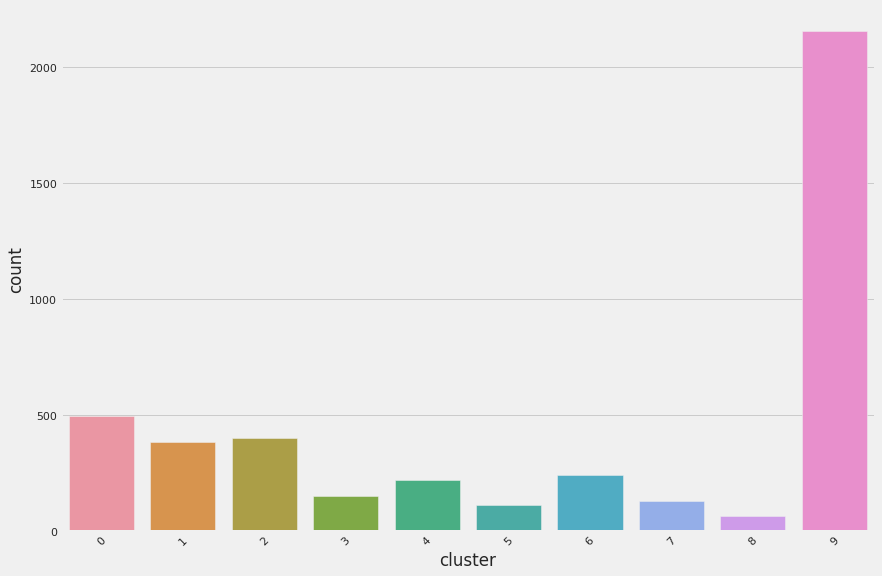

In [ ]:
sns.set(rc={'figure.figsize':(13,9)})
plt.style.use('fivethirtyeight')
ax = sns.countplot(x='cluster', data=tweet_vacc)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.show()

##Sentiment Analysis

In [ ]:
tweet_vacc['emotion']=''

In [ ]:
for i in range(1,tweet_vacc.shape[0]):
  text = tweet_vacc['lemmatized_string'][i]
  text_object = NRCLex(text)
  tweet_vacc['emotion'][i] = text_object.top_emotions[0][0]
  #tweets['emotion_score'][i] = text_object.top_emotions[0][1]
  #print("\n")
  #print(text_object.words)
  #print(text_object.top_emotions)
  #print(i)
  #print("\n")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



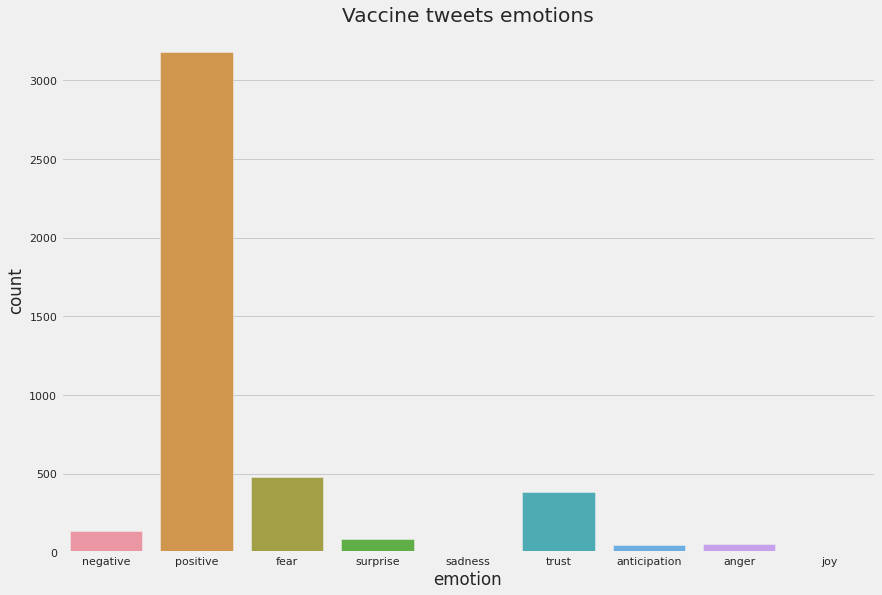

In [ ]:
ax = sns.countplot(x= 'emotion', data=tweet_vacc, order=['negative', 'positive', 'fear', 'surprise', 'sadness','trust','anticipation','anger', 'joy'])\
.set_title('Vaccine tweets emotions')
plt.show()

# Protests dataframe

In [ ]:
tweet_protest.head()

,index,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,clean_text,text_tokenized,text_lemmatized,text_stemmed,stemmed_string,lemmatized_string,day
0,166684,Anastasia Tamar,NaN,"PhD, ❤️ for ISRAEL ✡️🇸🇻, animals, truth, goodn...",2015-05-02 21:12:47,648,1035,124437,False,2020-08-30 09:06:07,Where’s the condemnation for the rioters and p...,['COVID19'],Twitter for iPhone,False,where condemnation rioters protesters here act...,"[condemnation, rioters, protesters, actual, up...","[condemnation, rioter, protester, actual, upda...","[condemn, rioter, protest, actual, updat, numb...",condemn rioter protest actual updat number cov...,condemnation rioter protester actual update nu...,2020-08-30
1,166697,The Connexion,France,France's English newspaper | Le journal frança...,2009-07-04 22:54:58,8081,1080,221,False,2020-08-30 09:05:42,An anti-mask protest in #Paris this weekend dr...,['Paris'],Twitter Web App,False,anti mask protest paris this weekend drew peop...,"[anti, mask, protest, paris, weekend, drew, pe...","[anti, mask, protest, paris, weekend, drew, pe...","[anti, mask, protest, pari, weekend, drew, peo...",anti mask protest pari weekend drew peopl end ...,anti mask protest paris weekend drew people en...,2020-08-30
2,166707,Nathan Nordland,NaN,NaN,2020-07-21 13:52:08,21,83,3489,False,2020-08-30 09:05:01,@theheraldsun He just needs to say he is a #BL...,"['BLM', 'COVID19']",Twitter for Android,False,theheraldsun just needs protester then good ap...,"[theheraldsun, needs, protester, good, apparen...","[theheraldsun, need, protester, good, apparent...","[theheraldsun, need, protest, good, appar, cov...",theheraldsun need protest good appar covid aff...,theheraldsun need protester good apparently co...,2020-08-30
3,166722,AJ McClain#3•5%#FBPE🏴󠁧󠁢󠁳󠁣󠁴󠁿,"Galloway, Scotland","Gallovidian writer\n\nGalloway, The Life & Tim...",2017-11-12 18:33:20,150,514,1192,False,2020-08-30 09:04:17,@DailyMirror @coralangs Impatience is killing ...,NaN,Twitter for Android,False,dailymirror coralangs impatience killing thous...,"[dailymirror, coralangs, impatience, killing, ...","[dailymirror, coralangs, impatience, kill, tho...","[dailymirror, coralang, impati, kill, thousand...",dailymirror coralang impati kill thousand want...,dailymirror coralangs impatience kill thousand...,2020-08-30
4,166762,The Fraser Faithful,"Fraser Field, Lynn, Mass.","#NavsMediaRow, the press table in Sec.207 at F...",2017-06-14 22:03:43,78,40,512,False,2020-08-30 09:02:12,"Oh my, gigantic #Covid19 ""Never Mind"" from @NY...",['Covid19'],Twitter Web App,False,gigantic covid never mind from nytimes always ...,"[gigantic, covid, never, mind, nytimes, always...","[gigantic, covid, never, mind, nytimes, always...","[gigant, covid, never, mind, nytim, alway, dos...",gigant covid never mind nytim alway dosag matt...,gigantic covid never mind nytimes always dosag...,2020-08-30


##TFIDF Vectorizer

In [ ]:
vectorizer = TfidfVectorizer(stop_words=stopwords_eng, 
max_features= 250, # keep top 1000 terms
max_df=0.3, 
min_df = 50, 
smooth_idf=True,
use_idf = True,
ngram_range=(1,3))

#vectorizer = TfidfVectorizer(use_idf = True, ngram_range=(1,2))

 
X = vectorizer.fit_transform(tweet_protest['lemmatized_string'])
terms = vectorizer.get_feature_names()

## Kmeans Clustering

In [ ]:
num_clusters = 10

km = KMeans(n_clusters=num_clusters,init='k-means++', max_iter=100, n_init=10, random_state=1)

labels = km.fit_predict(X)

In [ ]:
tweet_protest['cluster'] = labels

In [ ]:
#most important n-gramms (words) in each cluster

print("K-means clustering: \n")
asc_order_centroids = km.cluster_centers_.argsort()#[:, ::-1]
order_centroids = asc_order_centroids[:,::-1]
terms = vectorizer.get_feature_names()
for i in range(num_clusters):
    print ("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print (' %s' % terms[ind])
    print('\n')


K-means clustering: 

Cluster 0:
 govrondesantis
 conflict
 riot
 florida
 want
 protester
 trump
 quarantinelife
 make
 realdonaldtrump


Cluster 1:
 covid quarantine
 quarantine
 pandemic
 day
 coronavirus
 coronavirus covid
 corona
 people
 covid covid
 good


Cluster 2:
 coronavirus
 covid coronavirus
 coronavirus covid
 quarantine
 covid covid
 pandemic
 florida
 corona
 protest
 virus


Cluster 3:
 global pandemic
 global
 alert
 pandemic news
 global pandemic news
 pandemic
 news
 pandemic news coronavirus
 news coronavirus
 news coronavirus covid


Cluster 4:
 quarantine
 quarantine covid
 case
 people
 home
 day
 social
 travel
 hotel
 spain


Cluster 5:
 antibody
 covid antibody
 test
 antibody test
 study
 vaccine
 coronavirus
 patient
 people
 show


Cluster 6:
 mask
 wear
 anti mask
 anti
 protest
 people
 protester
 quarantine
 social
 pandemic


Cluster 7:
 anti
 anti masker
 masker
 vaccine
 lockdown
 trump
 right
 take
 protest
 corona


Cluster 8:
 test
 antigen
 posi

## Plot Cluster Size

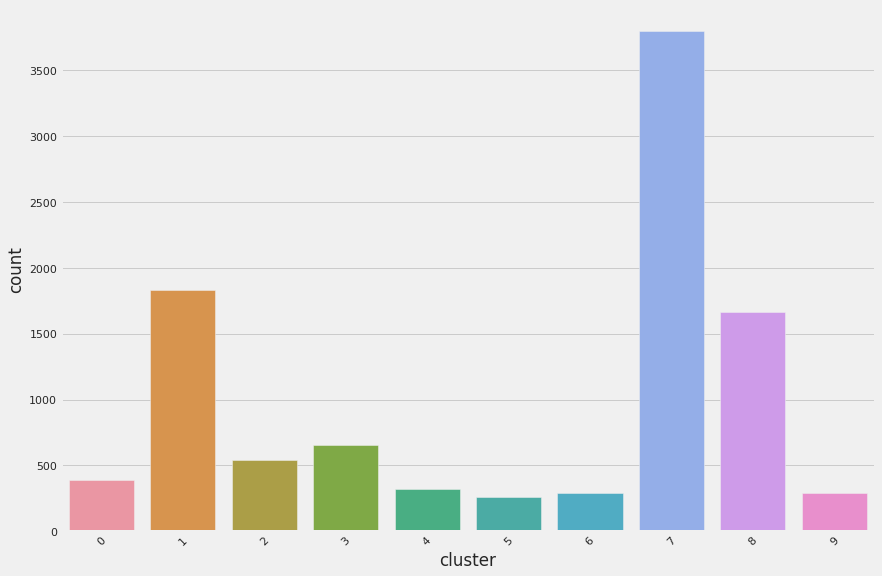

In [ ]:
sns.set(rc={'figure.figsize':(13,9)})
plt.style.use('fivethirtyeight')
ax = sns.countplot(x='cluster', data=tweet_masks)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.show()

##Sentiment Analysis

In [ ]:
tweet_protest['emotion']=''

In [ ]:
for i in range(1,tweet_protest.shape[0]):
  text = tweet_protest['lemmatized_string'][i]
  text_object = NRCLex(text)
  tweet_protest['emotion'][i] = text_object.top_emotions[0][0]
  #tweets['emotion_score'][i] = text_object.top_emotions[0][1]
  #print("\n")
  #print(text_object.words)
  #print(text_object.top_emotions)
  #print(i)
  #print("\n")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



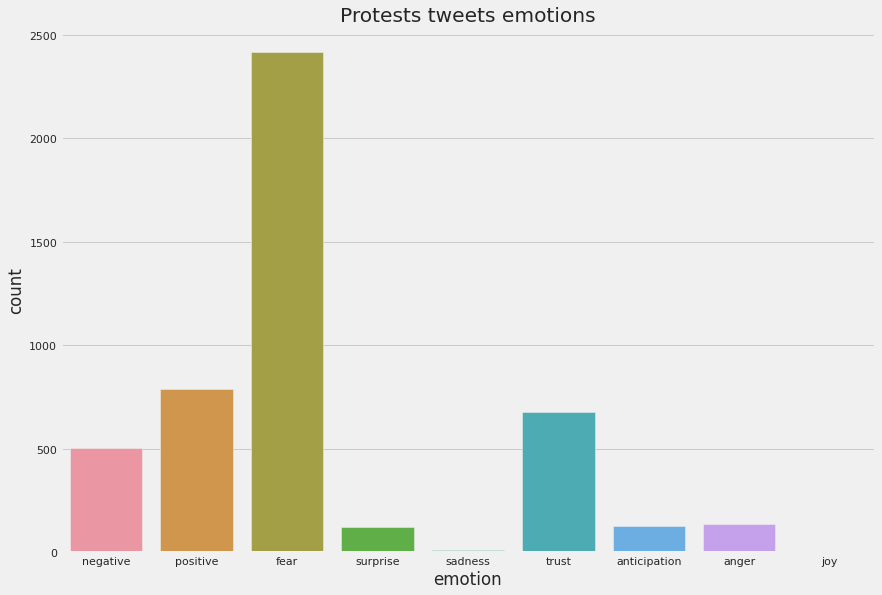

In [ ]:
ax = sns.countplot(x= 'emotion', data=tweet_protest, order=['negative', 'positive', 'fear', 'surprise', 'sadness','trust','anticipation','anger', 'joy'])\
.set_title('Protests tweets emotions')
plt.show()

# Hoax Dataframe

In [ ]:
tweet_hoax.head()

,index,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,clean_text,text_tokenized,text_lemmatized,text_stemmed,stemmed_string,lemmatized_string,day
0,166692,𝓔𝓶𝓖,AirForce1,#WalkingSociety Founder. #CashAppInBio $Emilio...,2010-05-30 00:59:30,1779,4055,71696,False,2020-08-30 09:06:00,I’ve been pushing this for a few weeks now @C...,NaN,Twitter for iPhone,False,been pushing this weeks cdcgov this their webs...,"[pushing, weeks, cdcgov, website, count, influ...","[push, week, cdcgov, website, count, influenza...","[push, week, cdcgov, websit, count, influenza,...",push week cdcgov websit count influenza pneumo...,push week cdcgov website count influenza pneum...,2020-08-30
1,166753,Crushed,Glasgow,Formerly of the 3rd Light Mounted Cash Registe...,2011-05-26 17:58:23,255,729,3262,False,2020-08-30 09:02:33,"Turns out, government has been pissing away £5...",['Covid19'],Twitter for Android,False,turns government been pissing away shot paying...,"[turns, government, pissing, away, shot, payin...","[turn, government, piss, away, shot, pay, soci...","[turn, govern, piss, away, shot, pay, social, ...",turn govern piss away shot pay social media in...,turn government piss away shot pay social medi...,2020-08-30
2,166805,IJMHN,NaN,International Journal of Mental Health Nursing,2012-06-04 11:56:08,2249,464,920,False,2020-08-30 09:00:44,This 👉 https://t.co/HFagAVLrGd 👈 rapid review ...,['COVID19'],Hootsuite Inc.,False,this hfagavlrgd rapid review three pandemics...,"[hfagavlrgd, rapid, review, three, pandemics, ...","[hfagavlrgd, rapid, review, three, pandemic, c...","[hfagavlrgd, rapid, review, three, pandem, cov...",hfagavlrgd rapid review three pandem covid mer...,hfagavlrgd rapid review three pandemic covid m...,2020-08-30
3,167069,Nilesh Hendre 🇮🇳,"Mumbai, India",🇮🇳 CHEMICAL ENGINEER,2018-11-09 17:43:43,3269,2291,29018,False,2020-08-30 08:46:43,Some stupid and idiots are spreading the fake ...,NaN,Twitter for Android,False,some stupid idiots spreading fake news that ns...,"[stupid, idiots, spreading, fake, news, nsitha...","[stupid, idiot, spread, fake, news, nsitharama...","[stupid, idiot, spread, fake, news, nsitharama...",stupid idiot spread fake news nsitharaman said...,stupid idiot spread fake news nsitharaman say ...,2020-08-30
4,167086,Presi Dente,"Brisbane, Queensland","The President. Satire, Reality, Bluntness, Mor...",2020-02-12 21:06:54,7,118,1091,False,2020-08-30 08:45:55,The END is near. 🛑 #COVID19 #riots #antimasqu...,"['COVID19', 'riots', 'antimasques', 'antimask'...",Twitter for iPhone,False,near covid riots antimasques antimask blmburnl...,"[near, covid, riots, antimasques, antimask, bl...","[near, covid, riot, antimasques, antimask, blm...","[near, covid, riot, antimasqu, antimask, blmbu...",near covid riot antimasqu antimask blmburnloot...,near covid riot antimasques antimask blmburnlo...,2020-08-30


##TFIDF Vectorizer

In [ ]:
vectorizer = TfidfVectorizer(stop_words=stopwords_eng, 
max_features= 250, # keep top 1000 terms
max_df=0.3, 
min_df = 50, 
smooth_idf=True,
use_idf = True,
ngram_range=(1,3))

#vectorizer = TfidfVectorizer(use_idf = True, ngram_range=(1,2))

 
X = vectorizer.fit_transform(tweet_hoax['lemmatized_string'])
terms = vectorizer.get_feature_names()

## Kmeans Clustering

In [ ]:
num_clusters = 10

km = KMeans(n_clusters=num_clusters,init='k-means++', max_iter=100, n_init=10, random_state=1)

labels = km.fit_predict(X)

In [ ]:
tweet_hoax['cluster'] = labels

In [ ]:
#most important n-gramms (words) in each cluster

print("K-means clustering: \n")
asc_order_centroids = km.cluster_centers_.argsort()#[:, ::-1]
order_centroids = asc_order_centroids[:,::-1]
terms = vectorizer.get_feature_names()
for i in range(num_clusters):
    print ("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print (' %s' % terms[ind])
    print('\n')


K-means clustering: 

Cluster 0:
 chinavirus
 coronavirus
 china
 covid coronavirus
 virus
 people
 say
 pandemic
 mask
 make


Cluster 1:
 hoax
 call
 trump
 virus
 people
 realdonaldtrump
 coronavirus
 say
 pandemic
 like


Cluster 2:
 fake
 people
 realdonaldtrump
 trump
 death
 pandemic
 coronavirus
 like
 mask
 say


Cluster 3:
 influence
 pandemic
 trump
 need
 coronavirus
 people
 news
 make
 china
 covid coronavirus


Cluster 4:
 covidhoax
 coronavirus
 news
 fake news
 covid covid
 virus
 mask
 fake
 realdonaldtrump
 pandemic


Cluster 5:
 influencerchallange
 like
 people
 say
 need
 know
 make
 china
 death
 covid coronavirus


Cluster 6:
 plandemic
 coronavirus
 news
 trump
 covid coronavirus
 covid covid
 coronavirus covid
 people
 pandemic
 virus


Cluster 7:
 influenza
 death
 pandemic
 mask
 people
 news
 coronavirus
 need
 make
 say


Cluster 8:
 fakenews
 news
 coronavirus
 believe
 trump
 say
 people
 realdonaldtrump
 death
 make


Cluster 9:
 covid hoax
 hoax
 trump

## Plot Cluster Size

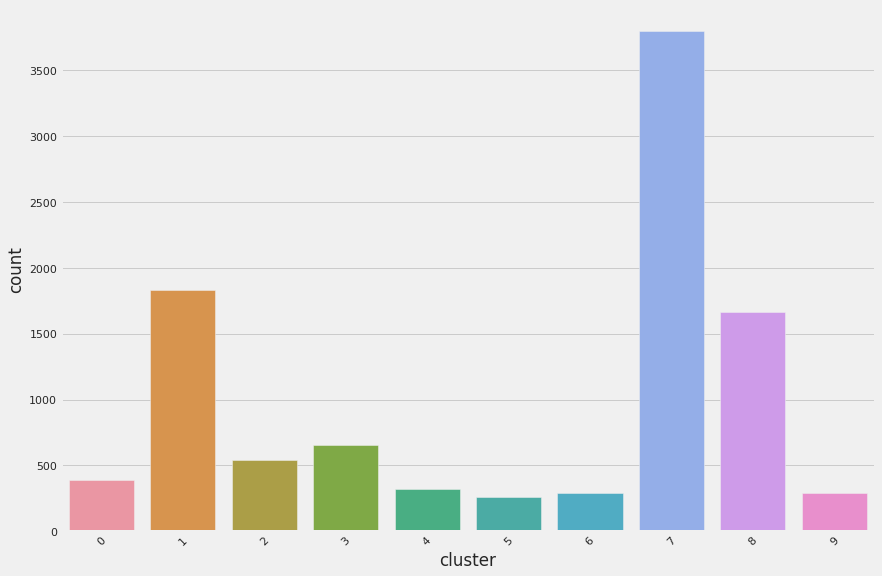

In [ ]:
sns.set(rc={'figure.figsize':(13,9)})
plt.style.use('fivethirtyeight')
ax = sns.countplot(x='cluster', data=tweet_masks)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.show()

##Sentiment Analysis

In [ ]:
tweet_hoax['emotion']=''

In [ ]:
for i in range(1,tweet_hoax.shape[0]):
  text = tweet_hoax['lemmatized_string'][i]
  text_object = NRCLex(text)
  tweet_hoax['emotion'][i] = text_object.top_emotions[0][0]
  #tweets['emotion_score'][i] = text_object.top_emotions[0][1]
  #print("\n")
  #print(text_object.words)
  #print(text_object.top_emotions)
  #print(i)
  #print("\n")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



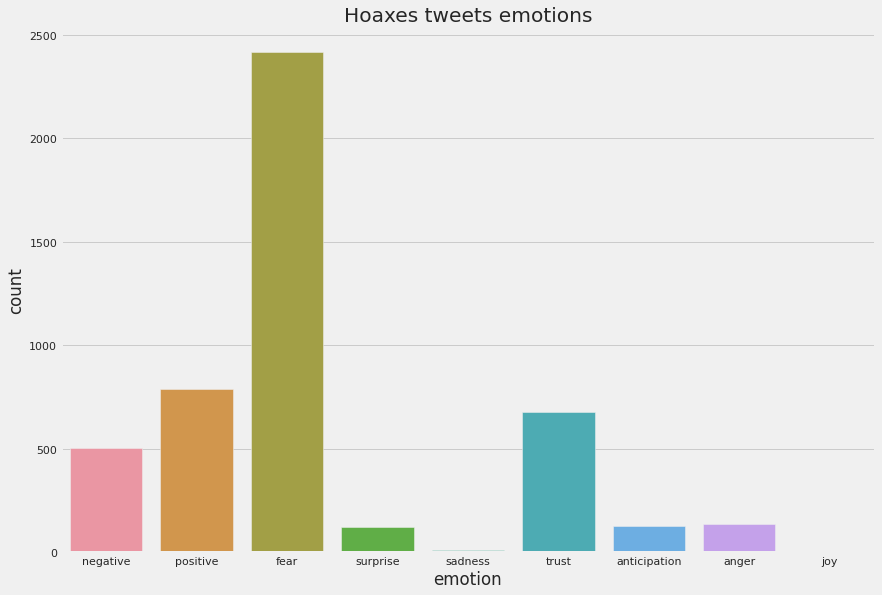

In [ ]:
ax = sns.countplot(x= 'emotion', data=tweet_protest, order=['negative', 'positive', 'fear', 'surprise', 'sadness','trust','anticipation','anger', 'joy'])\
.set_title('Hoaxes tweets emotions')
plt.show()